In [1]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject", "day", "sleep onset latency (minutes)", "label"])

In [3]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_

In [4]:
def cluster_DBSCAN(x, eps):
    db = DBSCAN(metric='euclidean', eps=eps)
    db.fit(x)
    return db.labels_

In [5]:
def cluster_HDBSCAN(x, min_cluster_size):
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
    hdbscan.fit(x)
    return hdbscan.labels_

In [6]:
def cluster_spectral(x, n_clusters):
    sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
    sc.fit(x)
    return sc.labels_

In [7]:
def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=17).fit(x)
    return kmeans.labels_

In [8]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [9]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

In [10]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True, cbar=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

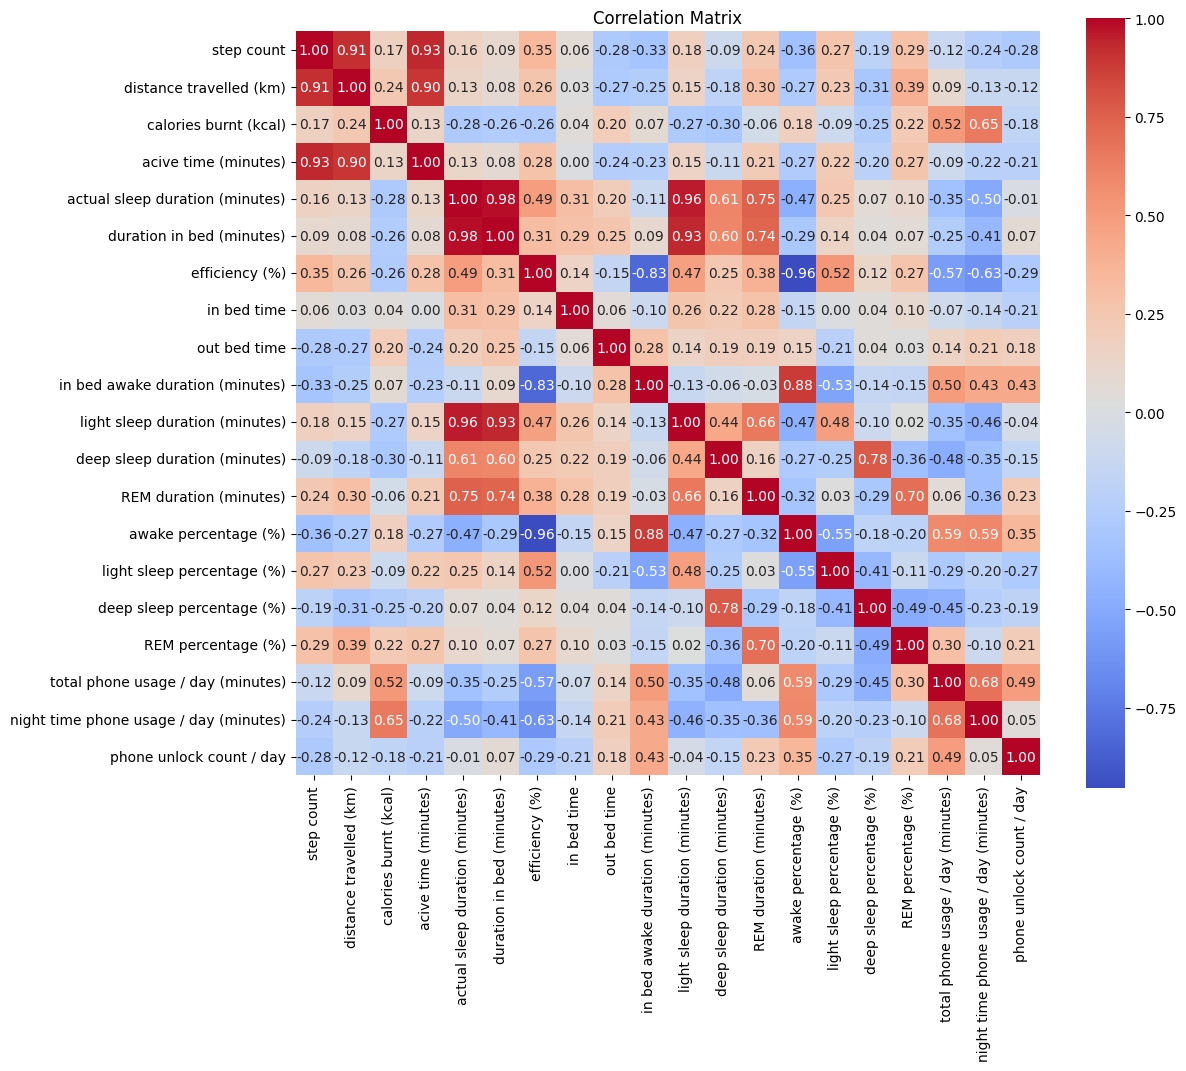

In [11]:
plot_correlation_matrix(base_df)

In [12]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

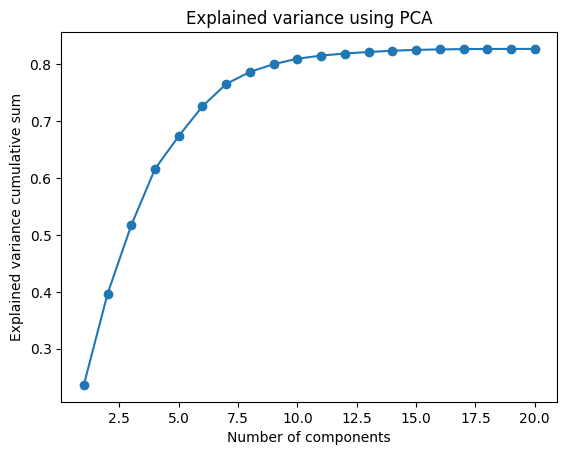

In [13]:
# Plot explained variance using PCA
pca = PCA(n_components=x_normalized.shape[1])
pca_reduced = pca.fit_transform(x_normalized)
plt.plot(range(1, x_normalized.shape[1] + 1), np.cumsum(pca.explained_variance_), marker='o')
plt.title('Explained variance using PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance cumulative sum')
plt.show()

In [14]:
# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=10, how='pca')

# Data reduced to 2 dimensions for plotting
x_reduced_plot = reduce_df(x_normalized, n_components=2, how='tsne')

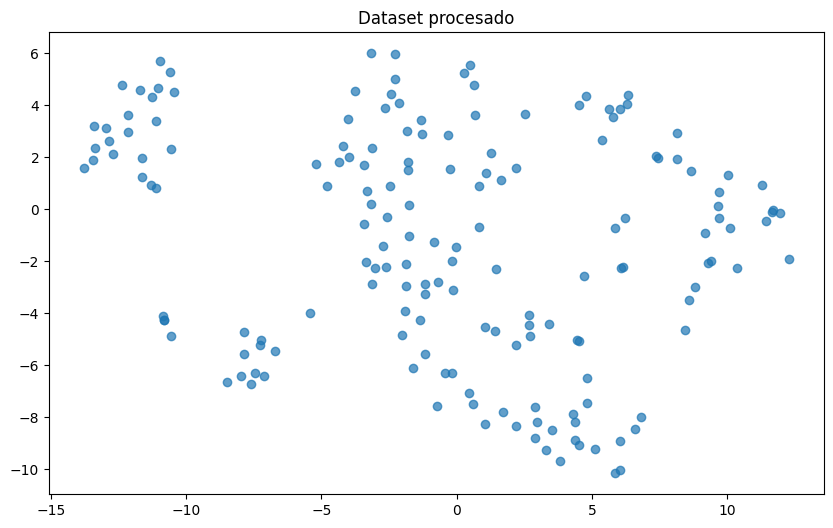

In [15]:
# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

In [16]:
def plot_silhouette(method, name, start=2, stop=10):
    silhouette_scores = []
    for n_clusters in range(start, stop):
        result_labels = method(x_reduced, n_clusters=n_clusters)
        silhouette_avg = silhouette_score(x_reduced, result_labels)
        silhouette_scores.append(silhouette_avg)
    plt.plot(range(2, 10), silhouette_scores, marker='o')
    plt.title('Silhouette score for ' + name)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

In [17]:
def show_clusters(labels, title):
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], c=labels, alpha=0.7)
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(81), mec="none",
                        label="C{:g}".format(i) if i != -1 else "Noise", ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(labels)]
    plt.legend(handles=handles, loc="upper right", title="Clusters")
    plt.title(title)
    plt.show()

In [18]:
# Copy base dataset, normalize values and add labels back
labeled_df = base_df.copy()
labeled_df = labeled_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
labeled_df['label'] = df['label']

In [52]:
def show_cluster_stats(labeled_df, labels, which="boxplot"):
    for cluster_num in np.unique(labels):
        cluster_data = labeled_df[labels == cluster_num]
        cluster_data_plot = labeled_df.drop(columns=["label", "in bed time"])[labels == cluster_num]
        
        if cluster_num == -1:
            print("Noise: ", len(cluster_data), "instances\n")
            continue

        print(f"Cluster {cluster_num}:")

        plt.figure().set_figwidth(60)
        plt.gca().set_ylim((0, 1))

        if which == "mean":
            means = cluster_data_plot.mean()
            plt.bar(means.index, means.values, align='center')
            plt.title(f"Mean for each variable in cluster {cluster_num}")
            plt.xlabel("Variables")
            plt.ylabel("Mean")
            plt.autoscale(enable=True, axis='x', tight=True)
            plt.show()
        elif which == "boxplot":
            cluster_data_plot.boxplot()
            plt.show()

        print("\nLabel count:")
        print(cluster_data['label'].value_counts())

        print("\n")

In [53]:
def create_spider_graph(labeled_df, labels, colors=None, transparent=False):
    cluster = 0
    plot_df = labeled_df.copy()
    plot_df['label'] = plot_df['label'].apply(lambda x: -1 if x == 2 else 0.5 if x == 1 else 1)
    variables = ["night time phone usage / day (minutes)", "calories burnt (kcal)", "distance travelled (km)", "efficiency (%)", "label"]
    display_labels = ["Uso de celular", "Calorias", "Distancia", "Eficiencia", "Calidad de sueño"]
    for cluster_num in np.unique(labels):
        cluster_data = plot_df[labels == cluster_num]
        means = cluster_data[variables].mean()
        fig = go.Figure(data=go.Scatterpolar(
                r=means.values,
                theta=display_labels,
                fill='tonext',
                fillcolor=f"rgba({",".join(map(str, colors[cluster]))}, 0.7)" if colors is not None else None,
                line_color=f"rgb({",".join(map(str, colors[cluster]))})" if colors is not None else None,
                name=f'Cluster {cluster_num}'
        ))
        fig.update_layout(
            paper_bgcolor="rgba(255, 255, 255, 0)" if transparent else None,
            polar=dict(
                radialaxis=dict(
                    visible=False,
                    range=[0, 1],
                ),
                angularaxis=dict(
                    tickfont=dict(
                        size=20
                    ),
                    rotation=18
                )
            ),
            showlegend=False
        )

        config = {
            'toImageButtonOptions': {
                'format': 'png',
                'filename': f'SpiderGraph_Cluster{cluster_num}',
                'height': 600,
                'width': 700,
                'scale': 4
            }
        }

        fig.show(config=config)

        cluster += 1

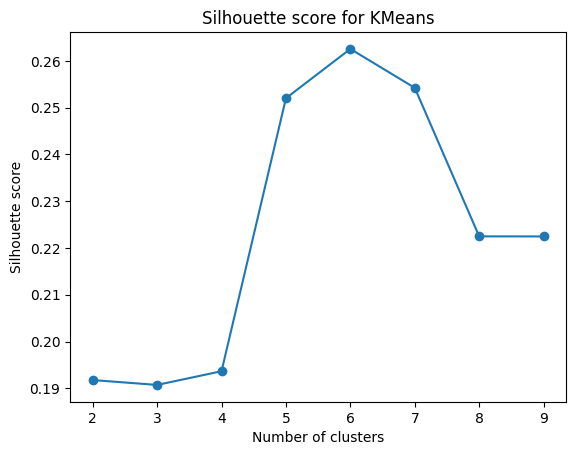

In [54]:
plot_silhouette(cluster_kmeans, "KMeans")

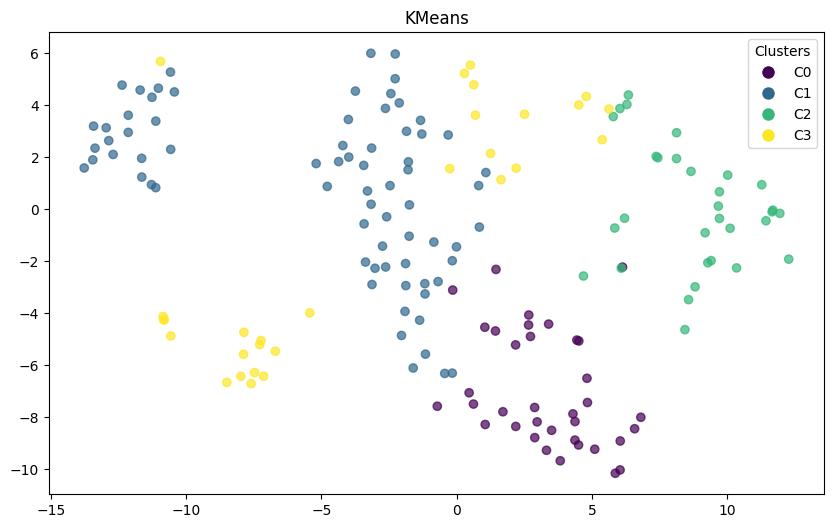

In [55]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=4)

show_clusters(kmeans_labels, "KMeans")

In [56]:
create_spider_graph(labeled_df, kmeans_labels, colors=[(29, 47, 82), (29, 47, 82), (162, 19, 25), (29, 47, 82)])

Cluster 0:


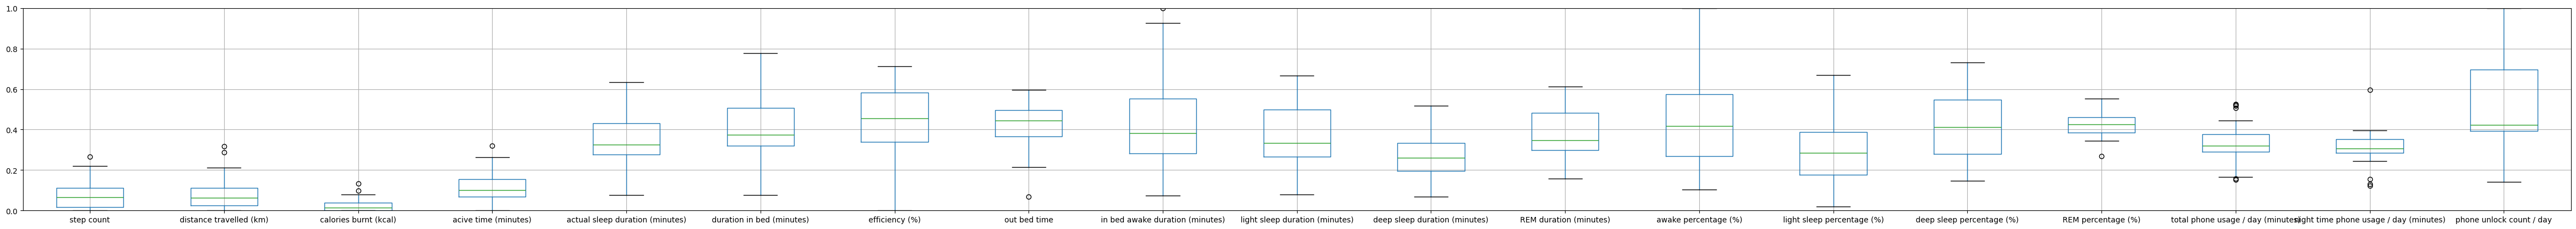


Label count:
label
1    32
2     4
Name: count, dtype: int64


Cluster 1:


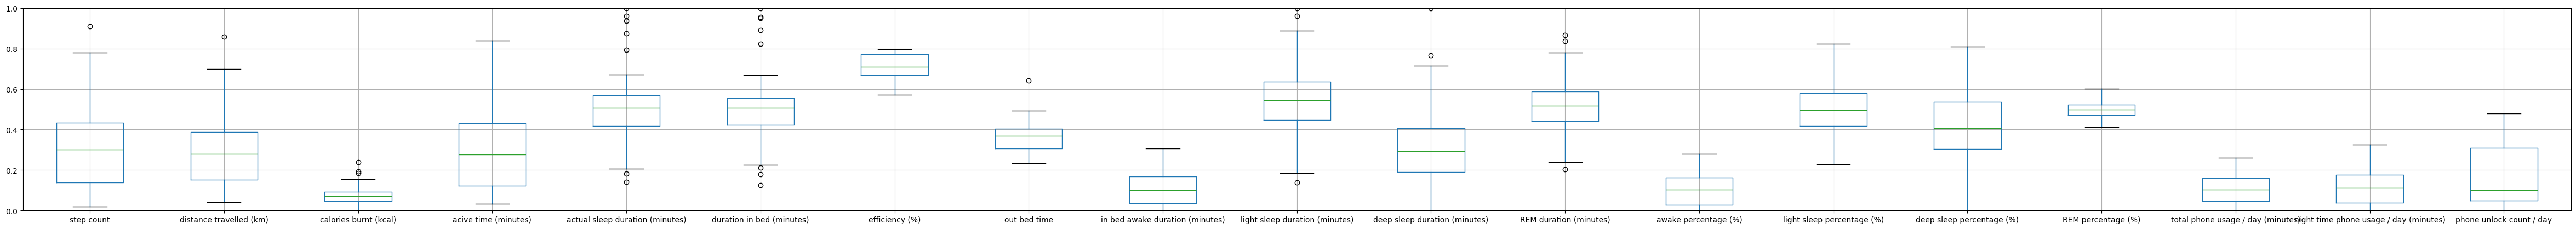


Label count:
label
0    54
1    18
Name: count, dtype: int64


Cluster 2:


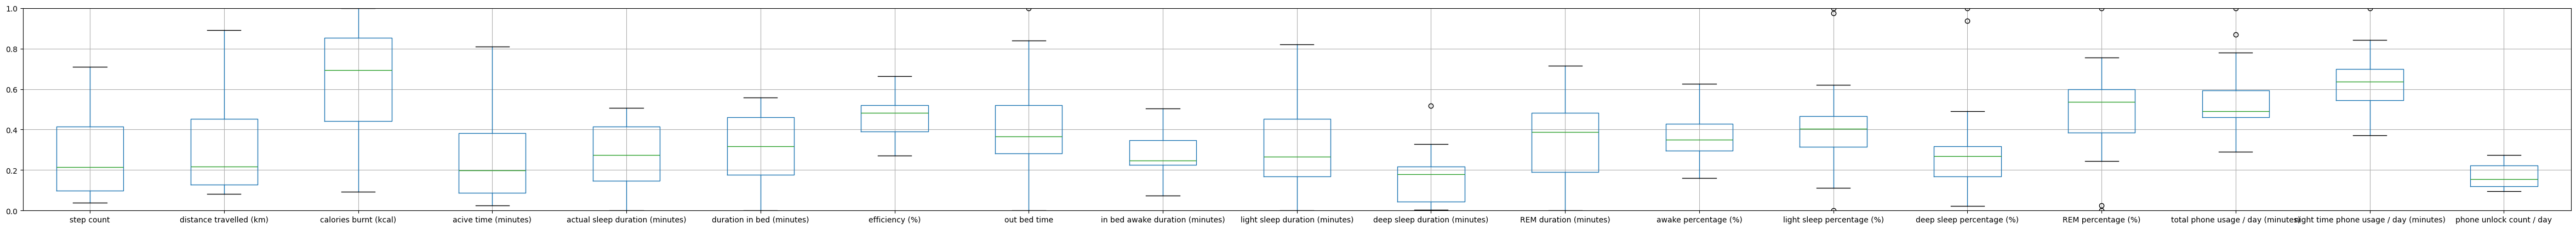


Label count:
label
1    24
2     4
0     3
Name: count, dtype: int64


Cluster 3:


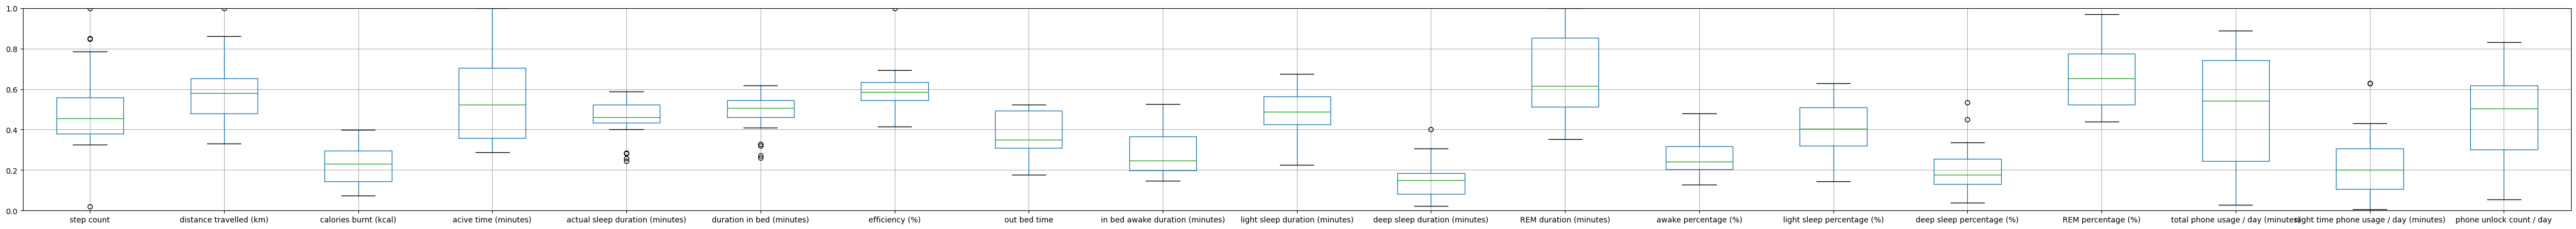


Label count:
label
0    15
1    14
Name: count, dtype: int64




In [57]:
show_cluster_stats(labeled_df, kmeans_labels)

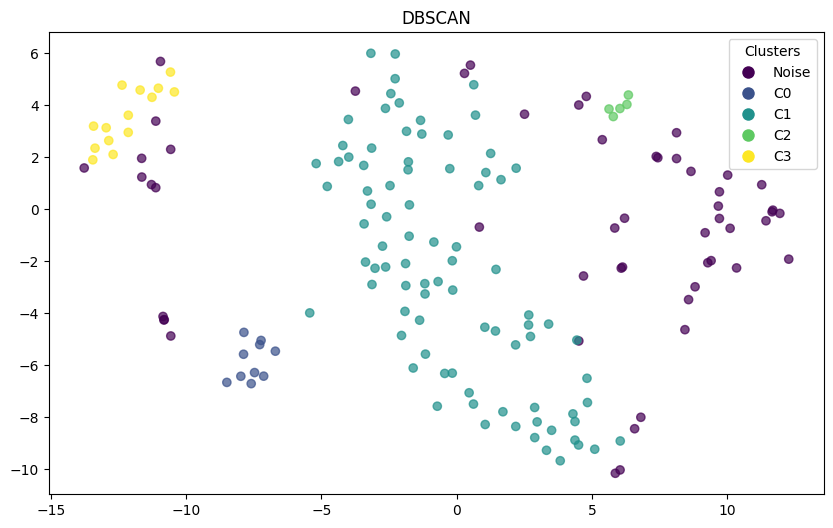

In [58]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced, 0.5)

show_clusters(dbscan_labels, "DBSCAN")

Noise:  53 instances

Cluster 0:


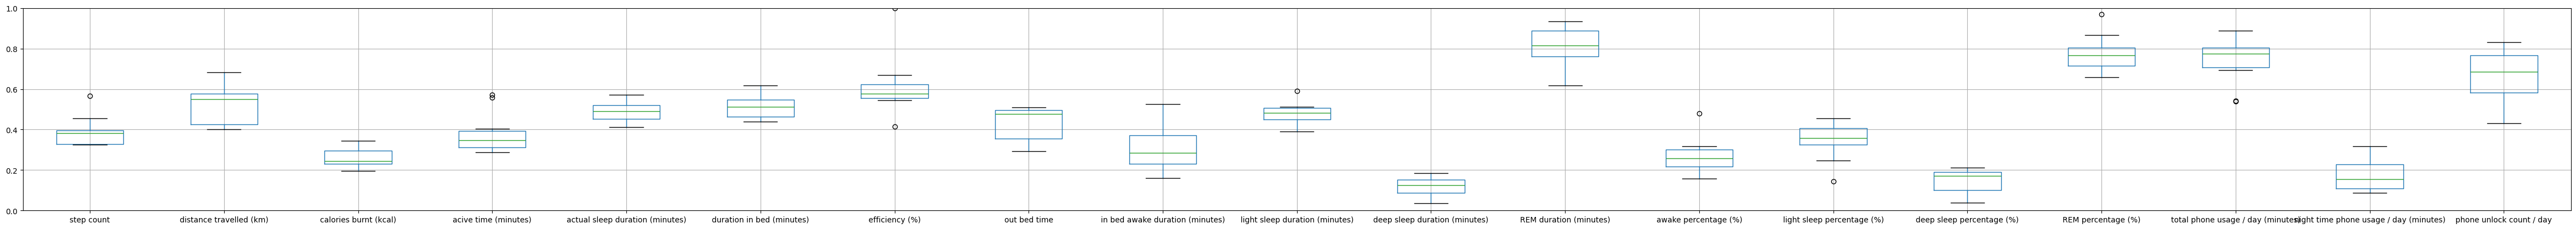


Label count:
label
1    6
0    4
Name: count, dtype: int64


Cluster 1:


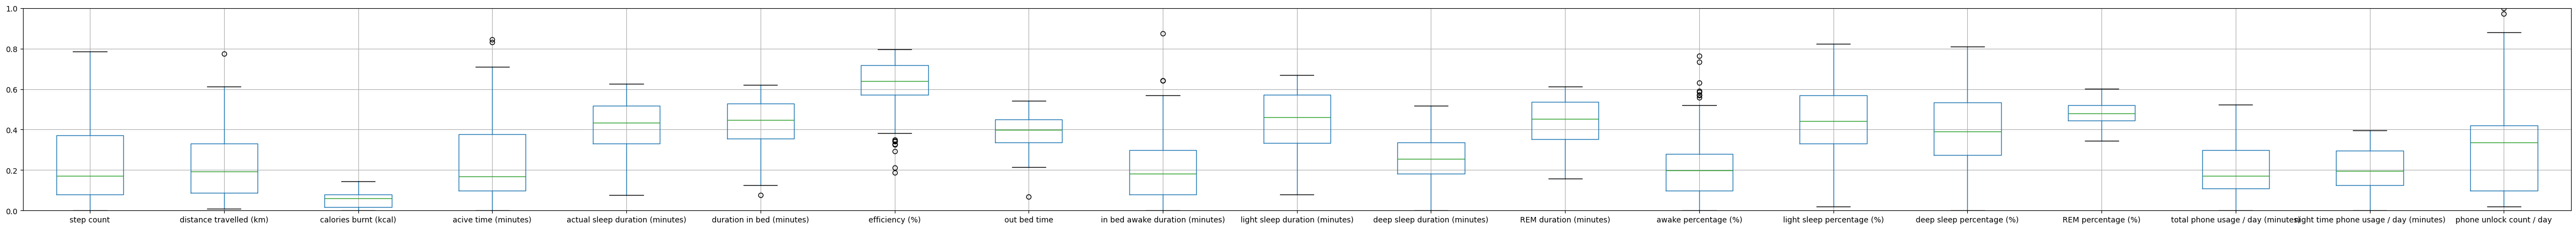


Label count:
label
1    42
0    42
2     2
Name: count, dtype: int64


Cluster 2:


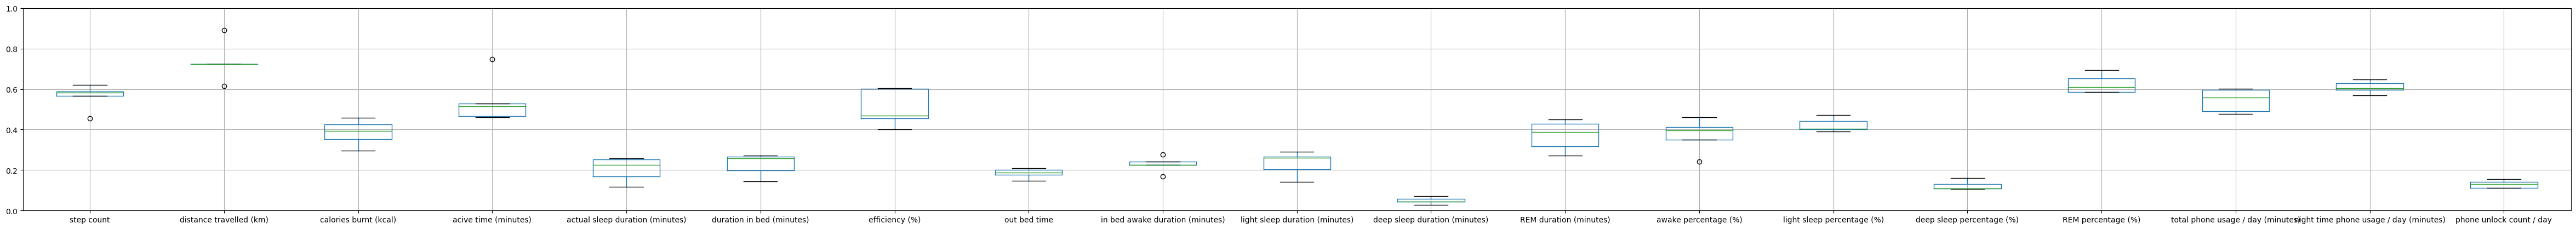


Label count:
label
1    5
Name: count, dtype: int64


Cluster 3:


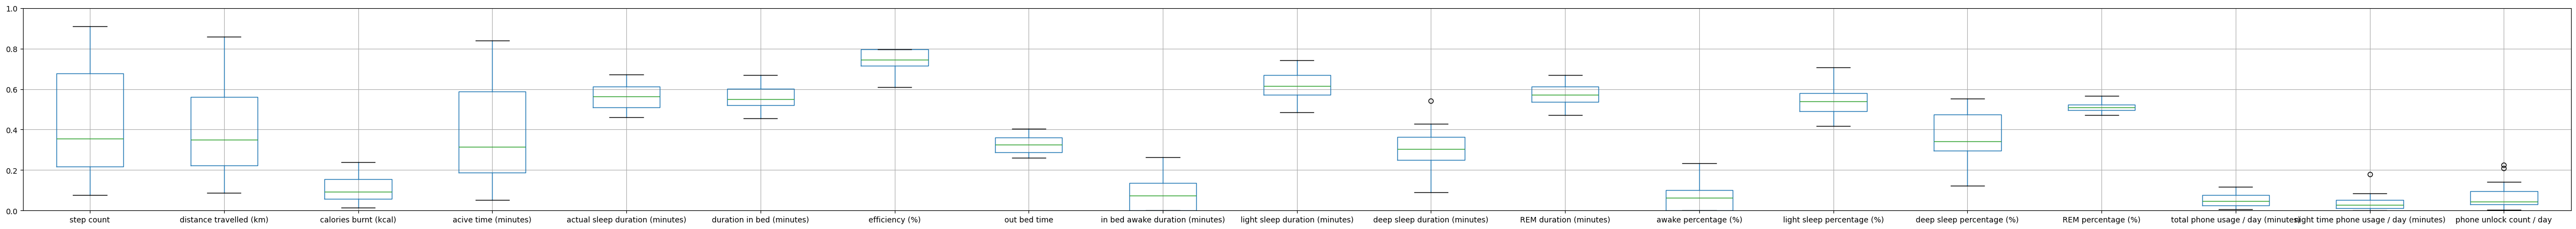


Label count:
label
0    13
1     1
Name: count, dtype: int64




In [59]:
show_cluster_stats(labeled_df, dbscan_labels)


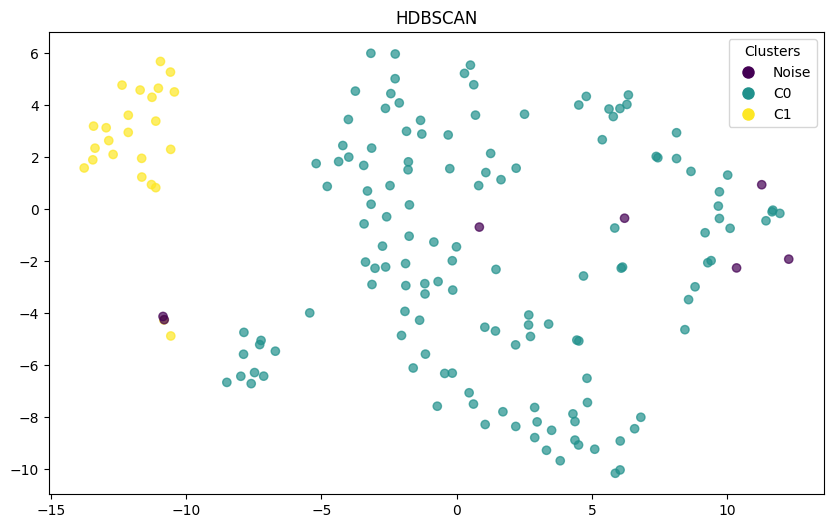

In [60]:
hdbscan_labels = cluster_HDBSCAN(x_reduced, 5)

show_clusters(hdbscan_labels, "HDBSCAN")

Noise:  7 instances

Cluster 0:


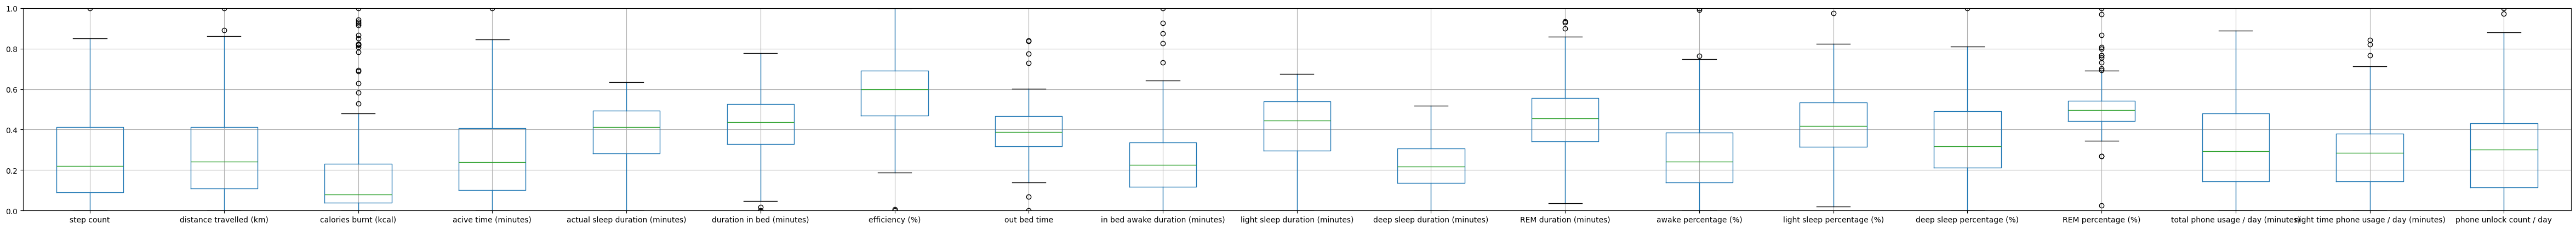


Label count:
label
1    77
0    53
2     7
Name: count, dtype: int64


Cluster 1:


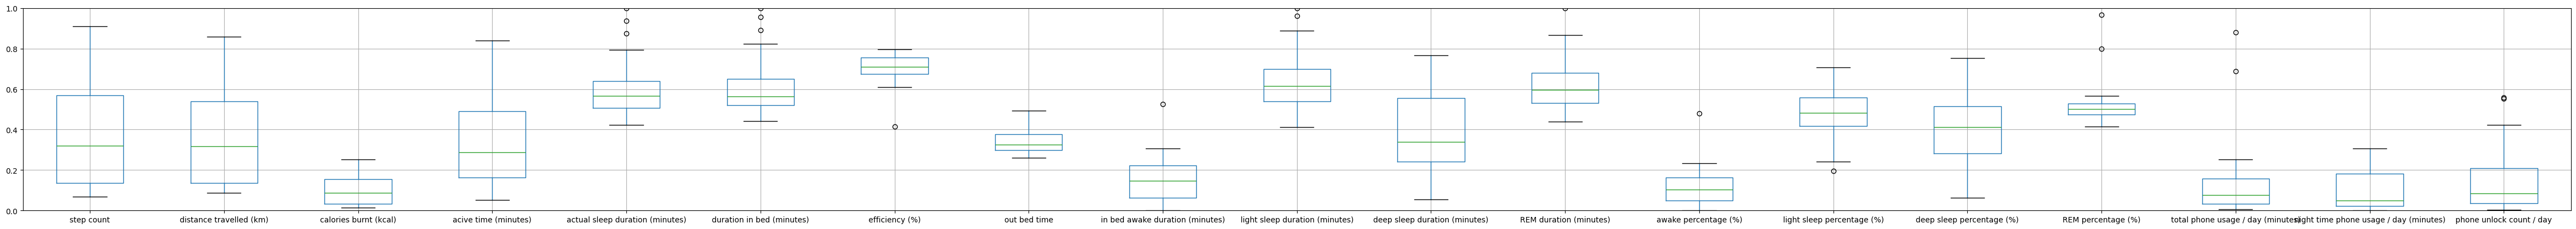


Label count:
label
0    16
1     8
Name: count, dtype: int64




In [61]:
show_cluster_stats(labeled_df, hdbscan_labels)

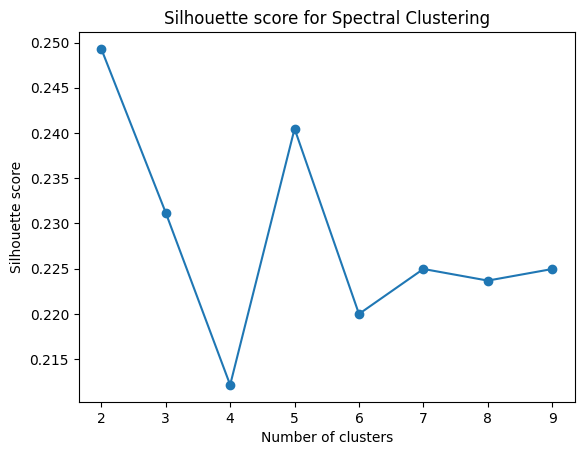

In [62]:
plot_silhouette(cluster_spectral, "Spectral Clustering")

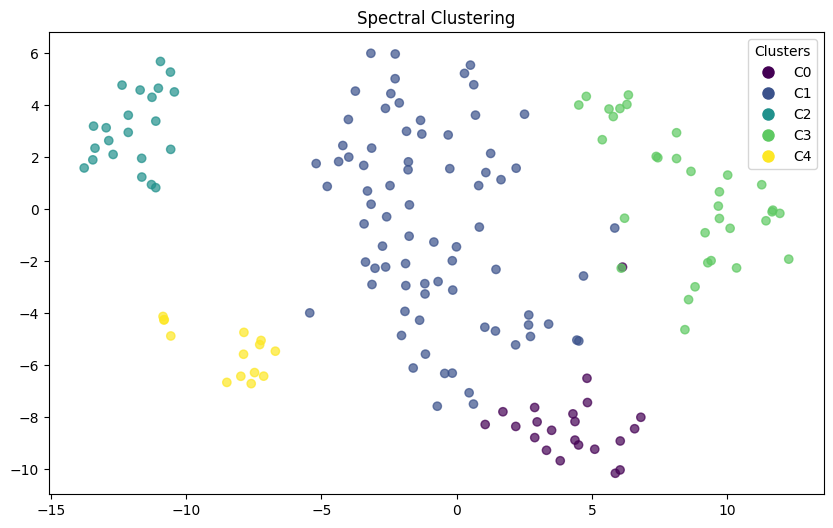

In [63]:
spectral_labels = cluster_spectral(x_reduced, n_clusters=5)

show_clusters(spectral_labels, "Spectral Clustering")

Cluster 0:


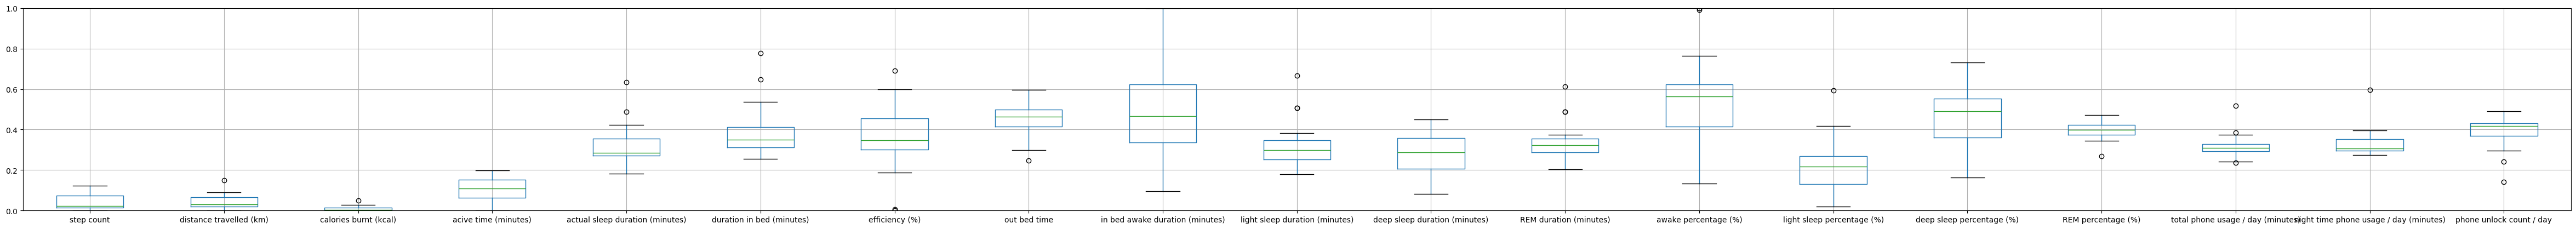


Label count:
label
1    18
2     4
Name: count, dtype: int64


Cluster 1:


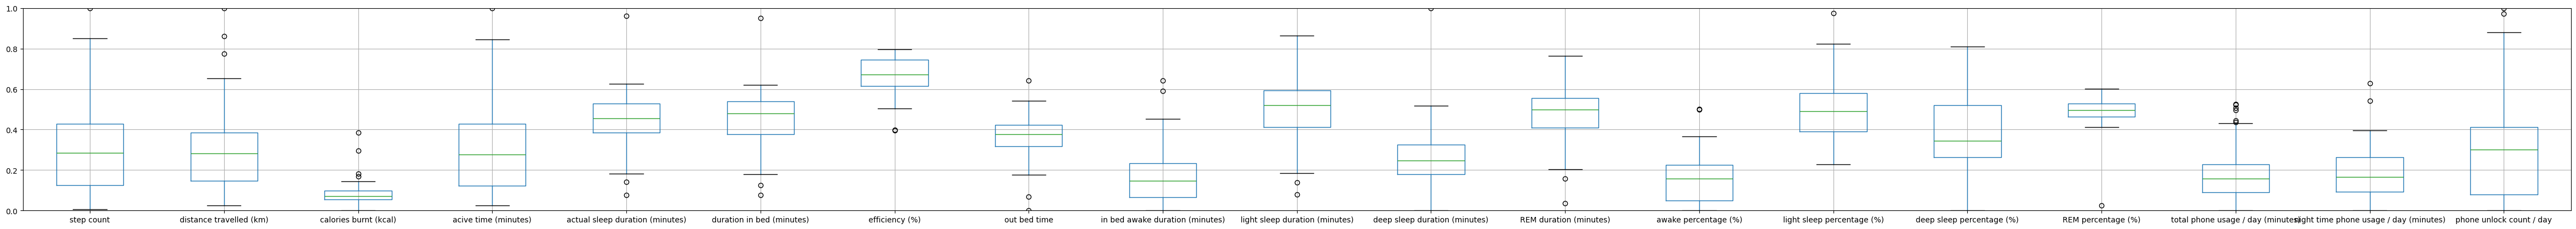


Label count:
label
0    47
1    30
Name: count, dtype: int64


Cluster 2:


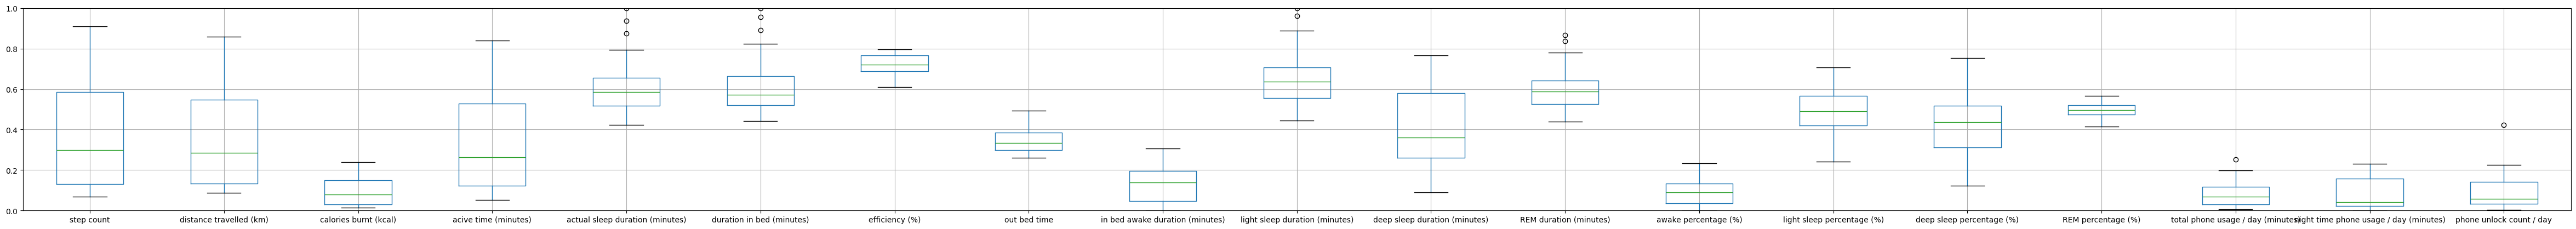


Label count:
label
0    16
1     6
Name: count, dtype: int64


Cluster 3:


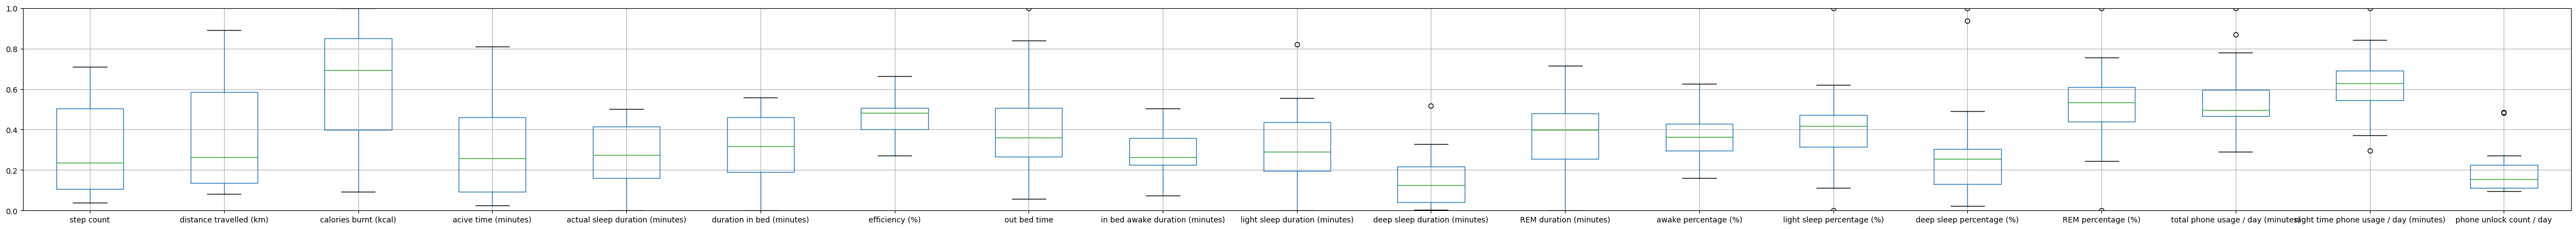


Label count:
label
1    26
2     4
0     3
Name: count, dtype: int64


Cluster 4:


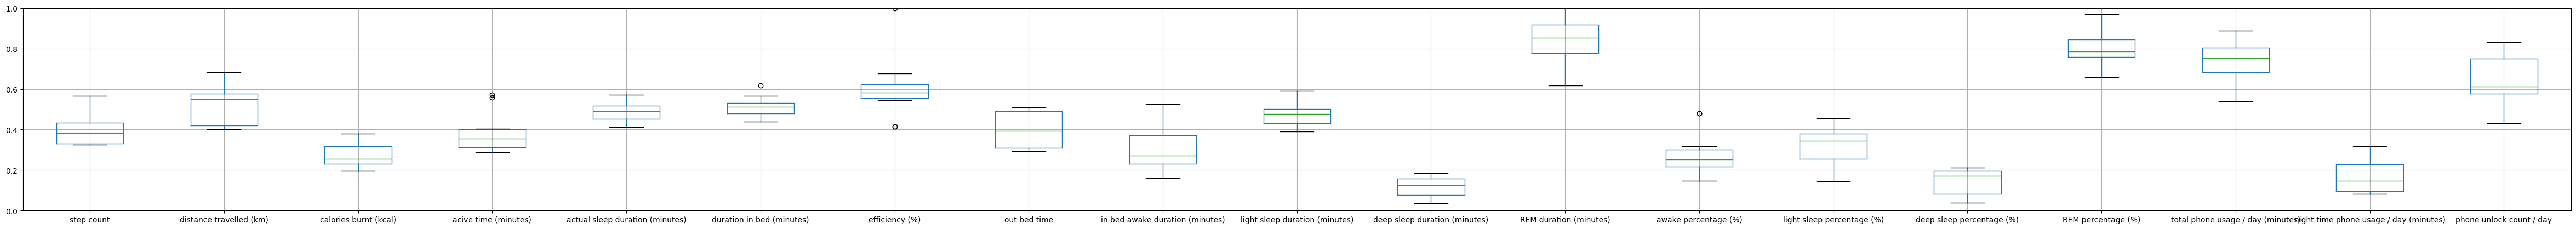


Label count:
label
1    8
0    6
Name: count, dtype: int64




In [64]:
show_cluster_stats(labeled_df, spectral_labels)

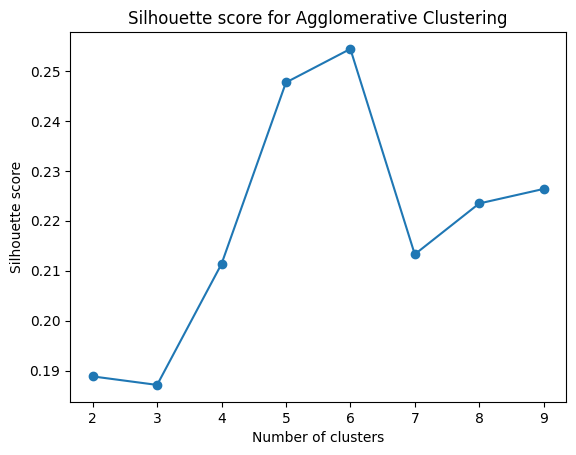

In [65]:
plot_silhouette(cluster_ac, "Agglomerative Clustering")

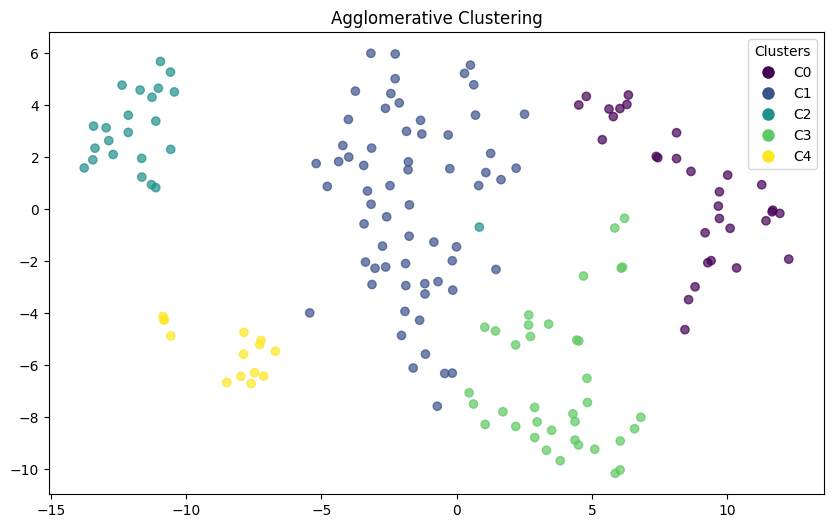

In [66]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=5)

show_clusters(agglomerative_labels, "Agglomerative Clustering")

Cluster 0:


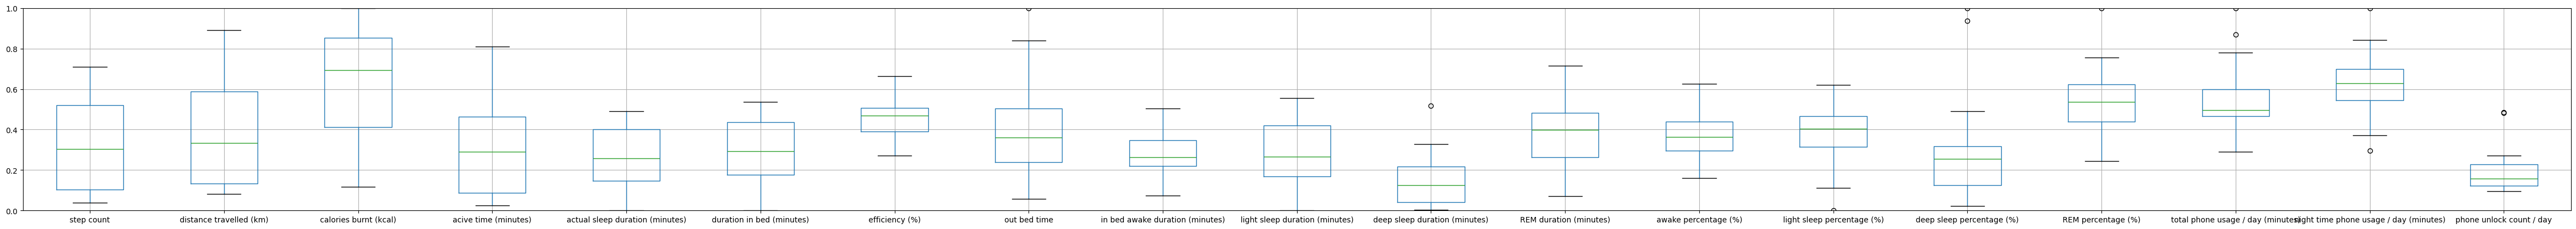


Label count:
label
1    24
2     4
0     3
Name: count, dtype: int64


Cluster 1:


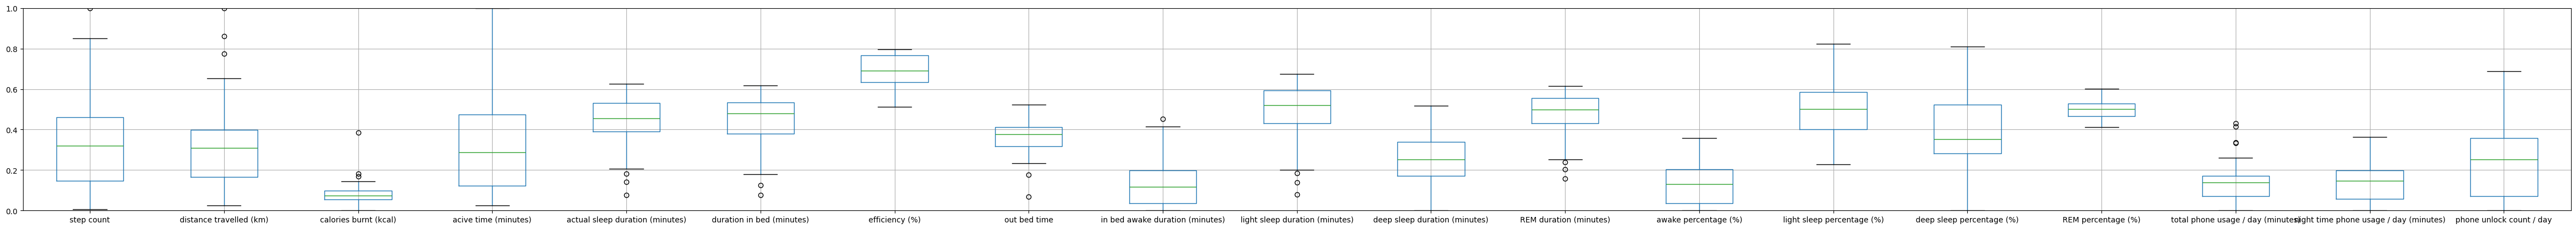


Label count:
label
0    46
1    17
Name: count, dtype: int64


Cluster 2:


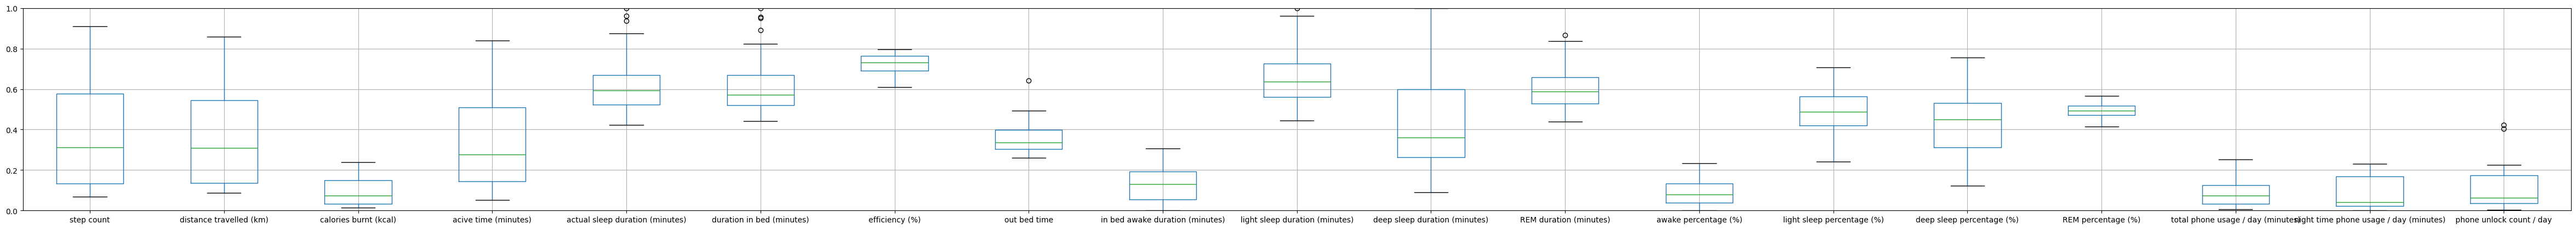


Label count:
label
0    17
1     6
Name: count, dtype: int64


Cluster 3:


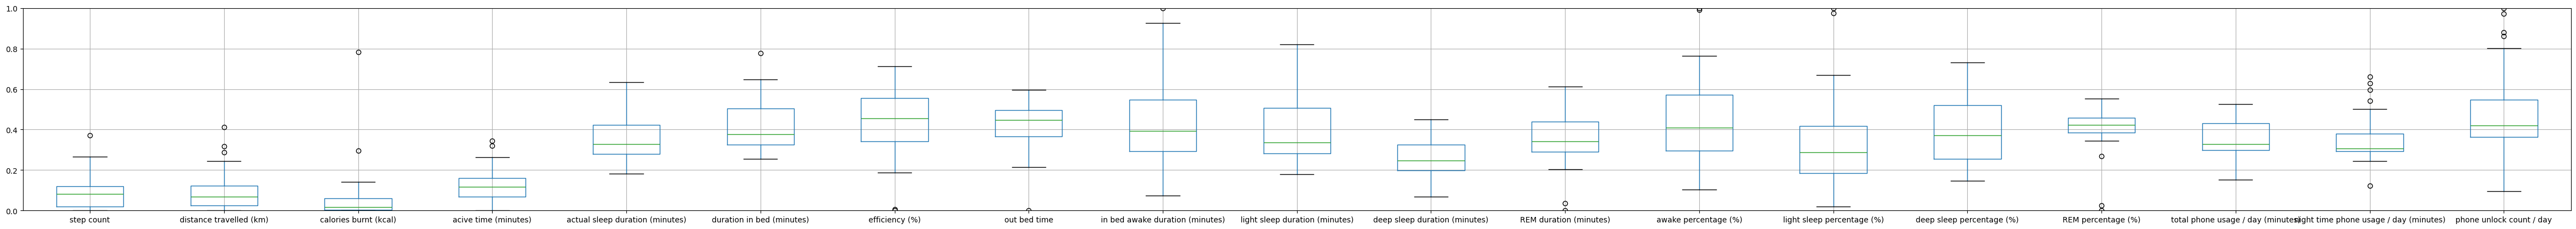


Label count:
label
1    33
2     4
Name: count, dtype: int64


Cluster 4:


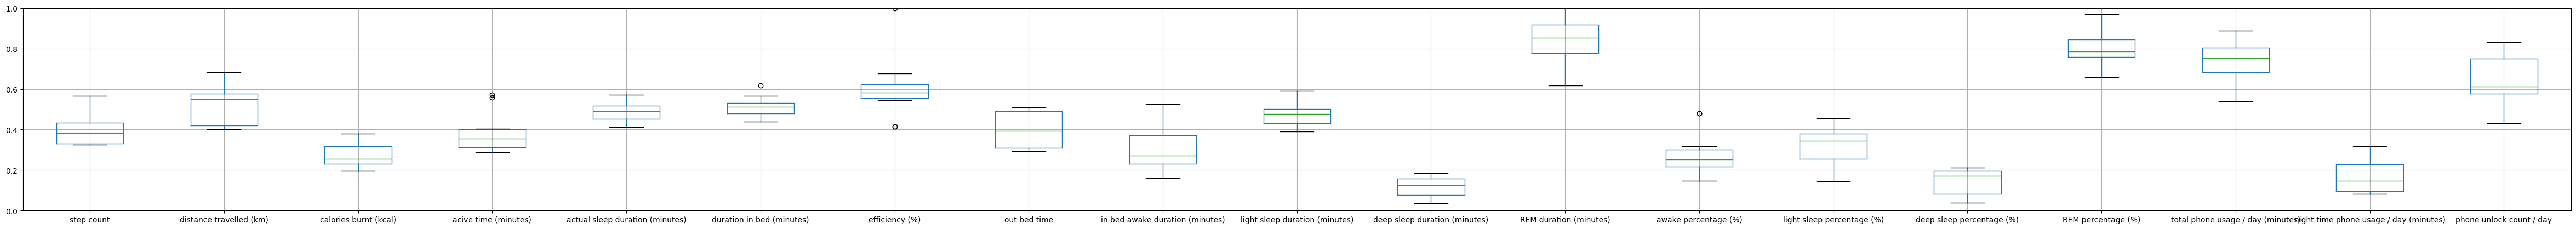


Label count:
label
1    8
0    6
Name: count, dtype: int64




In [67]:
show_cluster_stats(labeled_df, agglomerative_labels)